In [1]:
from manim import *
from matplotlib.pyplot import tight_layout

from manim_custom import *
from manim_mobject_svg import *
from manim_custom.models import BinaryTree

import os
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results"

quality = "ql"
config['background_color'] = WHITE

import numpy as np

try:
    import openseespy.opensees as ops
    def analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A_list, E_list):
        """
        Parameters:
            nodes: np.array of shape (n_nodes, 3)
            connectivity_matrix: np.array of shape (n_elements, 2)
            supports: dict {node_index: (fix_x, fix_y)}
            loads: dict {node_index: [Fx, Fy]}
            A_list: list of cross-sectional areas (length = n_elements)
            E_list: list of Young's moduli (length = n_elements)

        Returns:
            displacements: dict {node_index: [ux, uy]}
        """

        ops.wipe()
        ops.model('basic', '-ndm', 2, '-ndf', 2)

        # Create nodes
        for i, (x, y, _) in enumerate(nodes):
            ops.node(i, x, y)

        # Supports
        for node_id, (fix_x, fix_y) in supports.items():
            ops.fix(node_id, int(fix_x), int(fix_y))

        # Define elements and materials
        for i, (ni, nj) in enumerate(connectivity_matrix):
            E = E_list[i]
            A = A_list[i]
            ops.uniaxialMaterial("Elastic", i, E)
            ops.element("truss", i, int(ni), int(nj), A, i)

        # Apply loads
        ops.timeSeries("Linear", 1)
        ops.pattern("Plain", 1, 1)
        for node_id, (Fx, Fy) in loads.items():
            ops.load(node_id, Fx, Fy)

        # Static analysis
        ops.system("SparseGeneral")
        ops.numberer("RCM")
        ops.constraints("Plain")
        ops.integrator("LoadControl", 1.0)
        ops.algorithm("Linear")
        ops.analysis("Static")
        ops.analyze(1)

        # Get displacements
        displacements = np.array([
            [ops.nodeDisp(i, 1), ops.nodeDisp(i, 2)]
            for i in range(len(nodes))
        ])

        forces = np.array([ops.eleResponse(i, 'axialForce')[0] for i in range(len(connectivity_matrix))])

        return displacements, forces
except Exception:
    pass


In [2]:
def moving_average(x, alpha):
    avg = [xi for xi in x]
    for i in range(1, len(x)):
        avg[i] = alpha * avg[i] + (1 - alpha) * avg[i - 1]
    return np.array(avg)

Manim Community v0.19.0

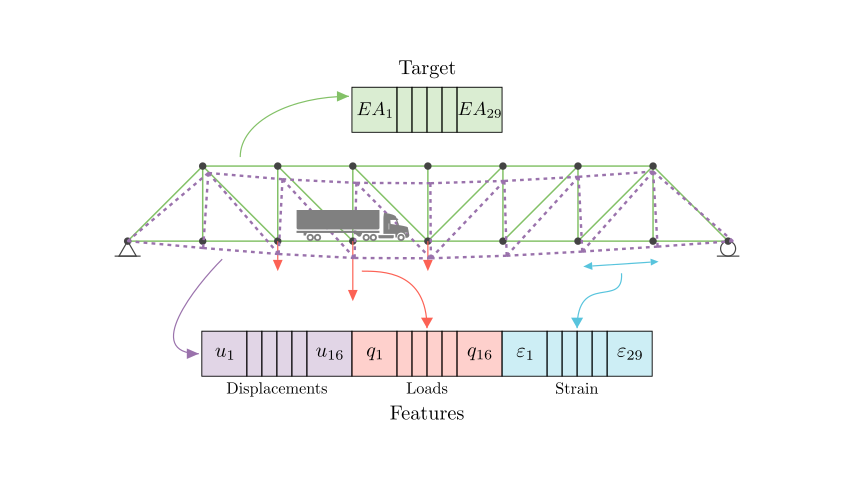

In [7]:
class DataSource(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(2)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [(0, 0, 0), (5, 0, 0), (10, 0, 0), (15, 0, 0), (20, 0, 0), (25, 0, 0), (30, 0, 0), (35, 0, 0), (40, 0, 0),
             (35, 5, 0), (30, 5, 0), (25, 5, 0), (20, 5, 0), (15, 5, 0), (10, 5, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 8: (False, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),
                                        (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 0),
                                        (1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9),
                                        (2, 15), (3, 14), (4, 13), (4, 11), (5, 10), (6, 9)])
        loads = {
            2: [0., -500e3],
            3: [0., -1000e3],
            4: [0., -500e3],
        }

        A = [.1] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_color': GREEN, 'stroke_width': 5},
                  node_style={'radius': .25, 'color': DARK_GRAY},
                  support_style={'height': 1, 'color': DARK_GRAY},
                  load_style={'scale': 4},
                  tip_style={'tip_length': .75, 'tip_width': .65},
                  deformed_style={'dash_length': .25, 'stroke_width': 8},
                  display_node_labels=False,
                  display_load_labels=False,
                  display_member_labels=False)

        g.move_to(ORIGIN)
        g.overlap_deformation(100)
        g.update()

        for load in g.loads:
            self.bring_to_front(load)

        truck = SVGMobject("ref_img/truck.svg")
        truck.scale(7.5 / truck.width)
        truck.next_to(g.loads, UP, buff=0)

        self.add(g, truck)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(.5)

        h = 1.5
        w = h
        h_fold = h / 3
        font_size = 65

        u_vars = self.create_variables(h, w, h_fold, angle=PI / 2,
                                       text_1=Tex(r"$u_1$", color=BLACK, font_size=font_size),
                                       text_2=Tex(r"$u_{16}$", color=BLACK, font_size=font_size),
                                       color=BLACK, fill_color=PURPLE, fill_opacity=.3)
        q_vars = self.create_variables(h, w, h_fold, angle=PI / 2,
                                       text_1=Tex(r"$q_1$", color=BLACK, font_size=font_size),
                                       text_2=Tex(r"$q_{16}$", color=BLACK, font_size=font_size),
                                       color=BLACK, fill_color=RED, fill_opacity=.3).next_to(u_vars, RIGHT, 0.)
        strain_vars = self.create_variables(h, w, h_fold, angle=PI / 2,
                                            text_1=Tex(r"$\varepsilon_1$", color=BLACK, font_size=font_size),
                                            text_2=Tex(r"$\varepsilon_{29}$", color=BLACK, font_size=font_size),
                                            color=BLACK, fill_color=BLUE, fill_opacity=.3).next_to(q_vars, RIGHT, 0.)
        ea_vars = self.create_variables(h, w, h_fold, angle=PI / 2,
                                        text_1=Tex(r"$EA_1$", color=BLACK, font_size=font_size-5),
                                        text_2=Tex(r"$EA_{29}$", color=BLACK, font_size=font_size-5),
                                        color=BLACK, fill_color=GREEN, fill_opacity=.3)
        features = VGroup(u_vars, q_vars, strain_vars)
        target = VGroup(ea_vars)

        target.add(Tex(r"$\text{Target}$", font_size=font_size, color=BLACK).next_to(target, UP, .3))
        features.add(Tex(r"$\text{Displacements}$", font_size=font_size * .8, color=BLACK).next_to(u_vars, DOWN, .2),
                     Tex(r"$\text{Loads}$", font_size=font_size * .8, color=BLACK).next_to(q_vars, DOWN, .2),
                     Tex(r"$\text{Strain}$", font_size=font_size * .8, color=BLACK).next_to(strain_vars, DOWN, .2))
        features.add(Tex(r"$\text{Features}$", font_size=font_size, color=BLACK).next_to(features, DOWN, .3))

        features.next_to(g, DOWN, 1)
        target.next_to(g, UP, 1)

        tip_kwargs = {'length': .4, 'width': .35}

        arrow_target = VGroup(CubicBezier(g.members[14].get_center() + .3 * UP, g.members[14].get_center() + 1.5 * UP,
                                          target.get_left() + 2 * LEFT, target.get_left() + .1 * LEFT,
                                          color=GREEN, stroke_width=4),
                              ArrowTriangleFilledTip(**tip_kwargs, color=GREEN, start_angle=0.)
                              .next_to(target.get_left(), LEFT, .1))

        #v = Line(g.displaced_members[0].get_start(), g.displaced_members[0].get_end()).rotate(-PI / 2).get_vector()
        #v /= np.linalg.norm(v)
        v = DL

        arrow_u = VGroup(CubicBezier(g.members[1].get_center() + .6 * v, g.members[1].get_center() + 1.5 * v,
                                     u_vars.get_left() + 2 * LEFT, u_vars.get_left() + .1 * LEFT,
                                     color=PURPLE, stroke_width=4),
                         ArrowTriangleFilledTip(**tip_kwargs, color=PURPLE, start_angle=0.)
                         .next_to(u_vars.get_left(), LEFT, .1))

        arrow_q = VGroup(CubicBezier(g.loads[1].get_center() + .3 * RIGHT, g.loads[1].get_center() + 1 * RIGHT,
                                     q_vars.get_top() + 2 * UP, q_vars.get_top() + .1 * UP,
                                     color=RED, stroke_width=4),
                         ArrowTriangleFilledTip(**tip_kwargs, color=RED, start_angle=-PI / 2)
                         .next_to(q_vars.get_top(), UP, .1))

        idx = 6
        strain_mark = Line(g.displaced_members[idx].get_start(), g.displaced_members[idx].get_end(), color=BLUE)
        v = strain_mark.copy().rotate(-PI / 2).get_vector()
        v /= np.linalg.norm(v)
        strain_mark.shift(v * .5)
        (strain_mark
         .add_tip(**{f"tip_{k}": .75 * v for k, v in tip_kwargs.items()})
         .add_tip(**{f"tip_{k}": .75 * v for k, v in tip_kwargs.items()}, at_start=True))

        arrow_strain = VGroup(CubicBezier(strain_mark.get_center() + .3 * v, strain_mark.get_center() + 1.5 * v,
                                          strain_vars.get_top() + 2 * UP, strain_vars.get_top() + .1 * UP,
                                          color=BLUE, stroke_width=4),
                              ArrowTriangleFilledTip(**tip_kwargs, color=BLUE, start_angle=-PI / 2)
                              .next_to(strain_vars.get_top(), UP, .1))

        self.add(features, target, arrow_target, arrow_u, arrow_q, arrow_strain, strain_mark)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(1)
        path = "img/05-data_source.svg"
        all_group.to_svg(path, crop=True)

    def create_variables(self, h, w, h_fold, text_1=None, text_2=None, stroke_width=3, angle=None,
                         n_fold=4, color=BLACK, fill_color=None, fill_opacity=.5):
        variables = VGroup()
        variables.add(
            Rectangle(height=h, width=w, stroke_color=color, fill_color=fill_color, fill_opacity=fill_opacity,
                      stroke_width=stroke_width),
            *[Rectangle(height=h_fold, width=w, stroke_color=color, fill_color=fill_color, fill_opacity=fill_opacity,
                        stroke_width=stroke_width)
              for _ in range(n_fold)],
            Rectangle(height=h, width=w, stroke_color=color, fill_color=fill_color, fill_opacity=fill_opacity,
                      stroke_width=stroke_width))
        for i, variable in enumerate(variables[1:]):
            variable.next_to(variables[i], DOWN, buff=0)

        if angle: variables.rotate(angle)

        if text_1:
            text_1.move_to(variables[0])
            variables.add(text_1)
        if text_2:
            text_2.move_to(variables[-2])
            variables.add(text_2)

        return variables

%manim --format png -ql -v WARNING DataSource

In [5]:
server = MLFlowSession(PORT=5555, DIRECTORY=f"{runs_dir}/dummy/005", )
server.start(1)

MLflow server started at http://127.0.0.1:5555
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/dummy/005
Workers: 4
Process group: 36014


In [4]:
server = MLFlowSession(PORT=5550, DIRECTORY=f"{runs_dir}/121", )
server.start(1)

MLflow server started at http://127.0.0.1:5550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/121/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/121
Workers: 4
Process group: 35895


MLflow server started at http://127.0.0.1:5550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/121/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/121
Workers: 4
Process group: 39991


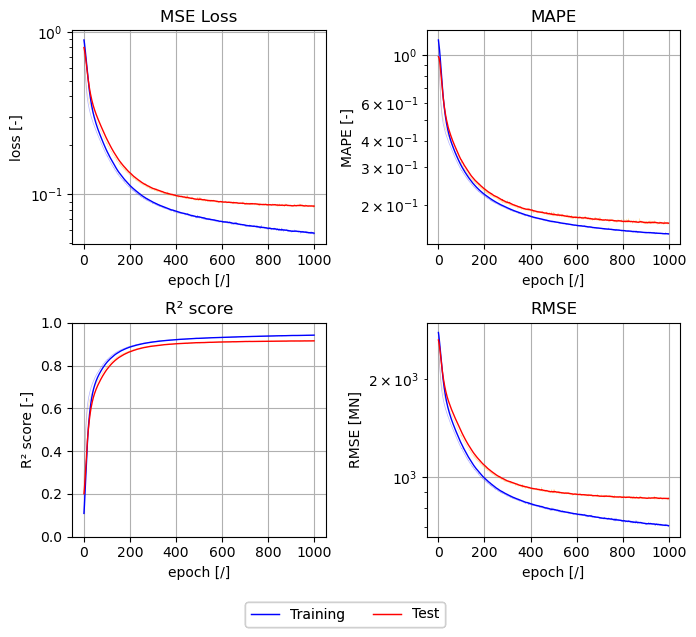

In [18]:
import mlflow
from tools import MLFlowSession
import matplotlib as mpl
from matplotlib import pyplot as plt

server = MLFlowSession(PORT=5550, DIRECTORY=f"{runs_dir}/121", )
server.start(1)

mlflow.set_tracking_uri(uri=server.url())
client = mlflow.MlflowClient()

# Extract Data
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
#runs_df = runs_df[runs_df['params.train_size'] == '4096']

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

sizes = set()
for size in runs_df['params.train_size'].unique():
    sizes.add(size)

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
for size in sizes:
    run_ids = runs_df[
        (runs_df['params.train_size'] == size)
        ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

# Plot
metrics = ['loss', 'mape', 'r2', 'rmse_MN']
figsize = (7, 6)
logs = [True, True, False, True]
legend_blank = False
legend_title = r'Training Dataset Size'
titles = ['MSE Loss', 'MAPE', 'R² score', 'RMSE']
axis_titles = [ 'loss [-]', 'MAPE [-]', 'R² score [-]', 'RMSE [MN]']
legend_ncols = 4

configs = ['16384']

labels = [f"{int(size)}" for size in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, 2 * len(configs)))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
axs = [ax for row in axs for ax in row]

for i, (title, y_axis_title, metric, log) in enumerate(zip(titles, axis_titles, metrics, logs)):
    ax = axs[i]
    # Plot the data but collect the handles for the legend
    config_handles = []
    for j, conf in enumerate(configs):
        # Store only the validation line handles for the legend
        l = len(results[conf][f'train_{metric}'])

        train_metric = results[conf][f'train_{metric}']
        test_metric = results[conf][f'val_{metric}']
        if title == 'Stiffness loss':
            train_metric = [1e12 * m for m in train_metric]
            test_metric = [1e12 * m for m in test_metric]
        ax.plot(np.arange(l), train_metric, ls='-', alpha=.3, lw=.5, c='b')[0]
        ax.plot(np.arange(l), test_metric, ls='-', alpha=.3, lw=.5, c='orange')[0]

        mean_train_metric = moving_average(train_metric, alpha=.1)
        mean_test_metric = moving_average(test_metric, alpha=.1)

        if i == 0:
            ax.plot(np.arange(l), mean_train_metric, ls='-', lw=1, c='b', label='Training')[0]
            ax.plot(np.arange(l), mean_test_metric, ls='-', lw=1, c='r', label='Test')[0]
        else:
            ax.plot(np.arange(l), mean_train_metric, ls='-', lw=1, c='b')[0]
            ax.plot(np.arange(l), mean_test_metric, ls='-', lw=1, c='r')[0]

    # Get the current position and size of the axis
    box = ax.get_position()
    # Reduce the width of the axis to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Combine both sets of handles and labels
    # Create a single legend with both line styles and configurations
    plt.figlegend(loc='upper center', ncols=legend_ncols,
                  bbox_to_anchor=(.5, 0), fontsize=10)

    ax.set_title(title, fontsize=12)
    if log:
        ax.set_yscale('log')
    ax.set_ylabel(f"{y_axis_title}", fontsize=10)
    ax.set_xlabel("epoch [/]", fontsize=10)
    ax.grid()

axs[2].set_ylim((0, 1))

fig.tight_layout(w_pad=4)

#for ax in axs[1:2]:
#    ax.set_ylim([min(.099, ax.get_ylim()[0]), ax.get_ylim()[1]])

plt.savefig("img/05-mse-members-training.pdf", transparent=True, bbox_inches='tight')
plt.show()
plt.close()

server.terminate()

MLflow server started at http://127.0.0.1:5551
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/121/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/121
Workers: 4
Process group: 38635


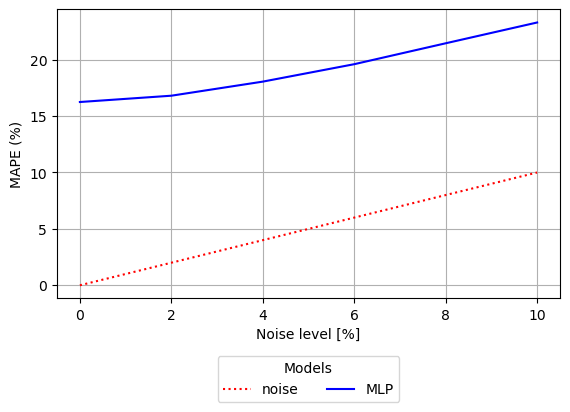

In [20]:
from tools import MLFlowSession
import mlflow
import numpy as np
import matplotlib.pyplot as plt

server = MLFlowSession(PORT=5551, DIRECTORY=f"{runs_dir}/121", )
server.start(1)

mlflow.set_tracking_uri(uri=server.url())
client = mlflow.MlflowClient()

# Extract Data
experiment = mlflow.get_experiment_by_name("noise_sensitivity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
#runs_df = runs_df[runs_df['params.train_size'] == '4096']

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

id = runs_df[
    (runs_df['params.train_size'] == str(2**14)) &
    (runs_df['params.test_set'] == 'member_ea')
]['run_id'].iloc[0]

mapes = np.array([m.value for m in client.get_metric_history(id, 'mape')])

# MAPE Plot
fig, ax = plt.subplots(figsize=(5.8, 4.3))
plt.plot(100 * np.linspace(0, .1, 11), 100 * np.linspace(0, .1, 11), label='noise', linestyle=':', c='r')
ax.plot(np.linspace(0, .1, len(mapes)) * 100, mapes * 100, linestyle='-', c='blue', label="MLP")


# Labels and formatting
ax.set_ylabel("MAPE (%)", fontsize=10)
ax.set_xlabel("Noise level [%]", fontsize=10)
ax.grid(True)

# Move legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.175), ncols=3, title="Models", fontsize=10)

lim = ax.get_ylim()
#ax.set_yticks(np.hstack((ax.get_yticks(), np.arange(0, 13, 2))))
ax.set_ylim(lim)

plt.tight_layout()  # Make room for legend

# Save
fig.savefig(r"img/05-mlp_mse_noise.pdf")

plt.show()
#server.terminate()

In [26]:
from dataset import FixedPrattTrussDataset
from torch.utils.data import DataLoader
import mlflow
from mlflow.pytorch import load_model
from tools import MLFlowSession
import os
import numpy as np
import matplotlib.pyplot as plt

# Setup a memoire directory variable
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results/"
device = 'mps'

server_mlp = MLFlowSession(PORT=6550, DIRECTORY=f"{runs_dir}/121", )
server_mlp.start(0)

server_hybrid = MLFlowSession(PORT=6555, DIRECTORY=f"{runs_dir}/124", )
server_hybrid.start(0)

test_dataset_dir = r"../data/dataset/pratt_truss_bridge_hyperstatic/test"

validation_ds = FixedPrattTrussDataset(f"{test_dataset_dir}/2_member_8192.hdf5", bisupported=True)
dl = DataLoader(validation_ds, batch_size=8192, shuffle=False)
_, y_exact, _, _, _, _ = dl.__iter__().__next__()
y_exact = y_exact.to(device)

f = .05
validation_ds = FixedPrattTrussDataset(
    f"{test_dataset_dir}/2_member_8192.hdf5",
    f_noise_loads=lambda size: np.random.normal(1, f / 2, size),
    f_noise_displacement=lambda size: np.random.normal(1, f / 2, size),
    f_noise_strain=lambda size: np.random.normal(1, f / 2, size),
    bisupported=True
)
dl = DataLoader(validation_ds, batch_size=8192, shuffle=False)
x, y, _, _, _, _ = dl.__iter__().__next__()

x = x.to(device)
y = y.to(device)

# MSE based
mlflow.set_tracking_uri(uri=server_mlp.url())
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
#runs_df = runs_df[runs_df['params.loss'] == 'mse']

artifact_uri = runs_df[runs_df['params.train_size'] == str(2**14)]['artifact_uri'].iloc[0]

uri = f"{artifact_uri}/input_scaler/"

input_scaler = load_model(uri)

uri = f"{artifact_uri}/target_scaler/"
target_scaler = load_model(uri)

uri = f"{artifact_uri}/mape_model/"
model = load_model(uri)

z_x = input_scaler.transform(x)
z_y = model(z_x)
y_pred_mlp = target_scaler.inverse_transform(z_y)

# PINN
mlflow.set_tracking_uri(uri=server_hybrid.url())
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
#runs_df = runs_df[runs_df['params.loss'] == 'hybrid']
artifact_uri = runs_df[runs_df['params.train_size'] == str(2**14)]['artifact_uri'].iloc[0]

uri = f"{artifact_uri}/input_scaler/"

input_scaler = load_model(uri)

uri = f"{artifact_uri}/target_scaler/"
target_scaler = load_model(uri)

uri = f"{artifact_uri}/mape_model/"
model = load_model(uri)

z_x = input_scaler.transform(x)
z_y = model(z_x)
y_pred_hybrid = target_scaler.inverse_transform(z_y)

idx = np.random.choice(2**13, 512, replace=False)

# Plot 1
fig, ax = plt.subplots(figsize=(5, 3))  # Wider figure for space
ax.scatter(y_exact.detach().cpu()[idx, :], y_pred_mlp.detach().cpu()[idx, :], s=2, c='blue', label='MSE')
ax.scatter(y_exact.detach().cpu()[idx, :], y_pred_hybrid.detach().cpu()[idx, :], s=2, c='orange', label='PINN')
ax.plot([y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        [y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        color='r', linestyle="-", label=r'$EA = \widehat{EA}$')
ax.set_ylabel('Predicted EA', fontsize=10)
ax.set_xlabel('True EA', fontsize=10)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_title('Comparison Between True and Predicted EA\nof MSE and PINN MLP on Out of Distribution Input', fontsize=12)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -.05), fontsize=10, ncols=3)
fig.savefig(r"img/05-member-5-percents-comparison-parity-plot.pdf", transparent=True, bbox_inches='tight')
plt.close('all')

# Plot 2
fig, ax = plt.subplots(figsize=(5, 3))  # Wider figure for space
ax.scatter(y_exact.detach().cpu()[idx, :], y_pred_mlp.detach().cpu()[idx, :], s=2, c='blue', label='MSE')
ax.plot([y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        [y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        color='r', linestyle="-", label=r'$EA = \widehat{EA}$')
ax.set_ylabel('Predicted EA', fontsize=10)
ax.set_xlabel('True EA', fontsize=10)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_title('Comparison', fontsize=12)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -.05), fontsize=10, ncols=3)
fig.savefig(r"img/05-member-5-percents-mlp-parity-plot.pdf", transparent=True, bbox_inches='tight')
plt.close('all')

# Plot 3
fig, ax = plt.subplots(figsize=(5, 3))  # Wider figure for space
ax.scatter(y_exact.detach().cpu()[idx, :], y_pred_hybrid.detach().cpu()[idx, :], s=2, c='orange', label='PINN')
ax.plot([y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        [y_exact.detach().cpu()[idx, :].min(), y_exact.detach().cpu()[idx, :].max()],
        color='r', linestyle="-", label=r'$EA = \widehat{EA}$')
ax.set_ylabel('Predicted EA', fontsize=10)
ax.set_xlabel('True EA', fontsize=10)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_title('Comparison Between True and Predicted EA\nof MSE and PINN MLP on Out of Distribution Input', fontsize=12)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -.05), fontsize=10, ncols=3)
fig.savefig(r"img/05-member-5-percents-hybrid-parity-plot.pdf", transparent=True, bbox_inches='tight')
plt.close('all')

server_mlp.terminate()
server_hybrid.terminate()

MLflow server started at http://127.0.0.1:6550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/121/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/121
Workers: 4
Process group: 38807
MLflow server started at http://127.0.0.1:6555
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/124/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/124
Workers: 4
Process group: 38809


MLflow server started at http://127.0.0.1:6800
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/121/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/121
Workers: 4
Process group: 39885
MLflow server started at http://127.0.0.1:6700
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/124/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/124
Workers: 4
Process group: 39887


[08/07/25 00:35:11] WARNING  Retrying (Retry(total=6, connect=6, read=7, redirect=7,          ]8;id=114889;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=679609;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/urllib3/connectionpool.py#868\868]8;;\
                             status=7)) after connection broken by                                                 
                             'NewConnectionError('<urllib3.connection.HTTPConnection object                        
                             at 0x33306d0a0>: Failed to establish a new connection: [Errno                         
                             61] Connection refused')':                                                            
                             /api/2.0/mlflow/experiments/get-by-name?experiment_name=training                      

[08/07/25 00:35:15] WARNING  Retrying (Retry(total=5, connect=5, read=7, redirect=7,          ]8;id=628829;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=666118;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/urllib3/connectionpool.py#868\868]8;;\
                             status=7)) after connection broken by                                                 
                             'NewConnectionError('<urllib3.connection.HTTPConnection object                        
                             at 0x336398cb0>: Failed to establish a new connection: [Errno                         
                             61] Connection refused')':                                                            
                             /api/2.0/mlflow/experiments/get-by-name?experiment_name=training                      

Manim Community v0.19.0

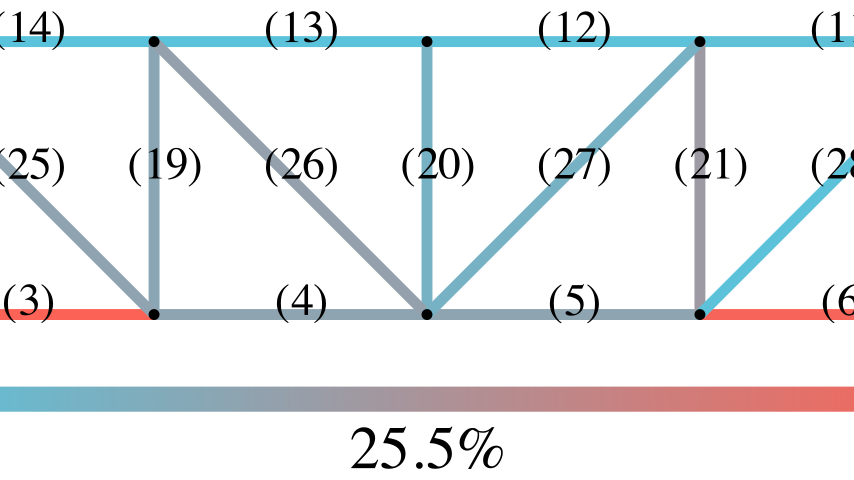

Manim Community v0.19.0

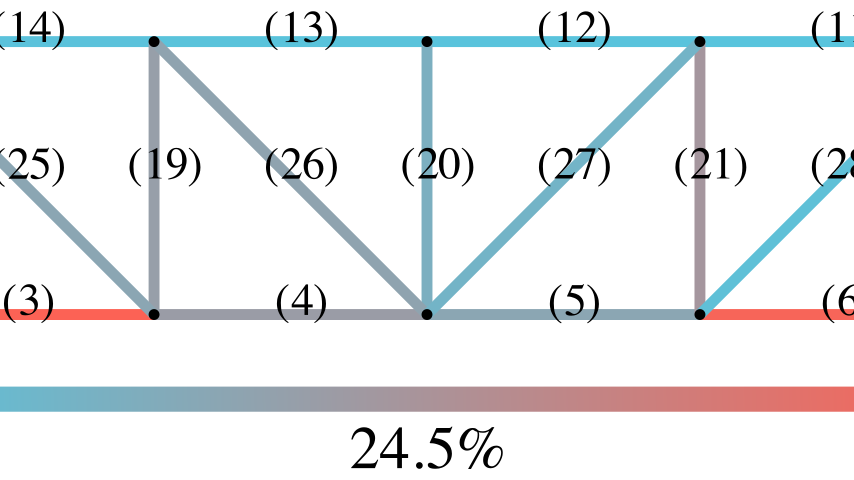

In [14]:
from dataset import FixedPrattTrussDataset
from torch.utils.data import DataLoader
import mlflow
from mlflow.pytorch import load_model
from tools import MLFlowSession
import os
import numpy as np
import matplotlib.pyplot as plt

# Setup a memoire directory variable
memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results/"
device = 'mps'

server_mlp = MLFlowSession(PORT=6800, DIRECTORY=f"{runs_dir}/121", )
server_mlp.start(0)

server_hybrid = MLFlowSession(PORT=6700, DIRECTORY=f"{runs_dir}/124", )
server_hybrid.start(0)

test_dataset_dir = r"../data/dataset/pratt_truss_bridge_hyperstatic/test"

validation_ds = FixedPrattTrussDataset(f"{test_dataset_dir}/2_member_8192.hdf5", bisupported=True)
dl = DataLoader(validation_ds, batch_size=8192, shuffle=False)
_, y_exact, _, _, _, _ = dl.__iter__().__next__()
y_exact = y_exact.to(device)

f = .05
validation_ds = FixedPrattTrussDataset(
    f"{test_dataset_dir}/2_member_8192.hdf5",
    f_noise_loads=lambda size: np.random.normal(1, f / 2, size),
    f_noise_displacement=lambda size: np.random.normal(1, f / 2, size),
    f_noise_strain=lambda size: np.random.normal(1, f / 2, size),
    bisupported=True
)
dl = DataLoader(validation_ds, batch_size=8192, shuffle=False)
x, y, _, _, _, _ = dl.__iter__().__next__()

x = x.to(device)
y = y.to(device)

# MSE based
mlflow.set_tracking_uri(uri=server_mlp.url())
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
#runs_df = runs_df[runs_df['params.loss'] == 'mse']

artifact_uri = runs_df[runs_df['params.train_size'] == str(2**14)]['artifact_uri'].iloc[0]

uri = f"{artifact_uri}/input_scaler/"

input_scaler = load_model(uri)

uri = f"{artifact_uri}/target_scaler/"
target_scaler = load_model(uri)

uri = f"{artifact_uri}/mape_model/"
model = load_model(uri)

z_x = input_scaler.transform(x)
z_y = model(z_x)
y_pred_mlp = target_scaler.inverse_transform(z_y)

# PINN
mlflow.set_tracking_uri(uri=server_hybrid.url())
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
#runs_df = runs_df[runs_df['params.loss'] == 'hybrid']
artifact_uri = runs_df[runs_df['params.train_size'] == str(2**14)]['artifact_uri'].iloc[0]

uri = f"{artifact_uri}/input_scaler/"

input_scaler = load_model(uri)

uri = f"{artifact_uri}/target_scaler/"
target_scaler = load_model(uri)

uri = f"{artifact_uri}/mape_model/"
model = load_model(uri)

z_x = input_scaler.transform(x)
z_y = model(z_x)
y_pred_hybrid = target_scaler.inverse_transform(z_y)

idx = np.random.choice(2**13, 512, replace=False)

# Plot

mape_mlp = ((y_pred_mlp - y).abs() / y).mean(dim=0).detach().cpu().numpy()
mape_hybrid = ((y_pred_hybrid - y).abs() / y).mean(dim=0).detach().cpu().numpy()

server_mlp.terminate()
server_hybrid.terminate()


class ErrorRepartition(MovingCameraScene):
    def __init__(self, mape, name, **kargs):
        super().__init__(**kargs)
        self.mape = mape
        self.name = name
        self.camera.frame.scale(1.1)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [(0, 0, 0), (5, 0, 0), (10, 0, 0), (15, 0, 0), (20, 0, 0), (25, 0, 0), (30, 0, 0), (35, 0, 0), (40, 0, 0),
             (35, 5, 0), (30, 5, 0), (25, 5, 0), (20, 5, 0), (15, 5, 0), (10, 5, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 8: (True, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),
                                        (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 0),
                                        (1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9),
                                        (2, 15), (3, 14), (4, 13), (4, 11), (5, 10), (6, 9)])
        loads = {}

        A = [.1] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  support_style={'height': 1},
                  display_node_labels=False,
                  display_loads=False,
                  display_load_labels=False,
                  display_member_labels=True,
                  member_label_style={'font_size':60})

        g.move_to(ORIGIN)
        g.update()

        for member, mape in zip(g.members, self.mape):
            mape_min = self.mape.min()
            mape_max = self.mape.max()
            alpha = (mape - mape_min) / (mape_max - mape_min)
            color = interpolate_color(BLUE, RED, alpha)
            member.set(color=color, stroke_width=20)

        # Create a vertical rectangle
        grad = Rectangle(width=0.5, height=20)

        # Apply gradient from bottom (blue) to top (red)
        grad.set_fill(color=[BLUE, RED], opacity=1)

        grad.rotate(-PI/2).next_to(g, DOWN, buff=.3)

        min_label = Text(f"{mape_min * 100:.3}%", color=BLACK, font_size=80).next_to(grad, LEFT)
        max_label = Text(f"{mape_max * 100:.3}%", color=BLACK, font_size=80).next_to(grad, RIGHT)
        mean_label = Text(f"{(mape_min + (mape_max - mape_min) /2) * 100:.3}%", color=BLACK, font_size=80).next_to(grad, DOWN)

        self.add(g, grad, min_label, max_label, mean_label)

        all_group = get_all_vmobjects(self)
        all_group.center()
        path = f"img/05-members-{self.name}-mape-repartition.svg"
        all_group.to_svg(path, crop=True)


class MSEErrorRepartition(ErrorRepartition):
    def __init__(self, **kargs):
        super().__init__(mape_mlp, 'mse', **kargs)


class PINNErrorRepartition(ErrorRepartition):
    def __init__(self, **kargs):
        super().__init__(mape_hybrid, 'pinn', **kargs)

%manim --format png -ql -v WARNING MSEErrorRepartition
%manim --format png -ql -v WARNING PINNErrorRepartition